# Explaining optimisation results (temporal)

This notebook put in relation the data between optimisation, learning rates and annotations correlations.

In [1]:
import nbhelper
import nbimports
from nbimports import *

In [2]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers=6)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# constants

In [3]:
n_bootstrap = 100

In [4]:
SAVEFIG = False

# load code and data

In [5]:
users, templates, annotations, A, B = nbhelper.load_data()

In [6]:
user_list = list(range(1, 13))

In [7]:
users_select = select(users, gesture=1, user=user_list)
annotations_select = select(annotations, user=user_list)

In [8]:
from importlib import reload

In [9]:
import correlations_app as capp
capp = reload(capp)

# optimisation

In [10]:
run_uid = "f1956943e2c54175aedac690a177c64c"
report, params = nbhelper.get_report_params_from_runid(run_uid, report_name="report.csv")

In [11]:
n_splits=2
n_repeats=8
random_state=42

In [12]:
dimensions = eval(params['data.dims'])
n_region = eval(params['n_region'])

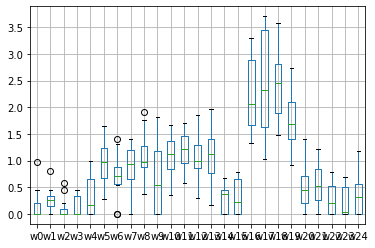

In [13]:
report.filter(regex="w.*").boxplot();

# color per segments

In [14]:
template = select(templates, template=1, version=0)

In [15]:
def ponderate(arr, weights):
    """Create an array of shape arr.shape[0] with weights.shape[0] equi-spaced
    segments of values weights.
    """
    n_weights = weights.shape[0]
    weights = weights.reshape(-1,1)
    region_size = arr.shape[0] // n_weights
    remainder = arr.shape[0] % n_weights
    vec = np.hstack([(weights * np.ones((n_weights, region_size))).reshape(-1),
                     weights[-1] * np.ones(remainder)])
    return vec

In [16]:
segmentation = ponderate(template, np.arange(25))

In [17]:
A = 370
B = 560
C = 850

In [18]:
[segmentation[i] for i in [A, B, C]]

[9.0, 13.0, 20.0]

In [19]:
N_SEGMENTS = 25

In [20]:
tab10 = sns.color_palette("tab10")

In [21]:
palette_mse_t_lr = {}
for i in np.arange(N_SEGMENTS):
    if i <= 9:
        palette_mse_t_lr[i] = tab10[0]
        palette_mse_t_lr[str(i)] = tab10[0]
    elif i <= 13:
        palette_mse_t_lr[i] = tab10[1]
        palette_mse_t_lr[str(i)] = tab10[1]
    elif i <= 20:
        palette_mse_t_lr[i] = tab10[2]
        palette_mse_t_lr[str(i)] = tab10[2]
    else:
        palette_mse_t_lr[i] = tab10[3]
        palette_mse_t_lr[str(i)] = tab10[3]

In [22]:
import sklearn.linear_model as sklm

In [23]:
import sklearn.model_selection as skms

## learning rates

In [24]:
compute_mse_temporal = capp.compute_mse_temporal(users_select, templates, dimensions, n_region, "mean", "mean")

In [25]:
%%time
mse_t = users_select.groupby(['user', 'day', 'gesture', 'trial']).parallel_apply(compute_mse_temporal)

CPU times: user 181 ms, sys: 92.1 ms, total: 273 ms
Wall time: 4.64 s


In [26]:
N_SEGMENTS = n_region

In [27]:
mse_t = capp.format_mse_temporal(mse_t, N_SEGMENTS)

In [28]:
mse_t_plot = mse_t[["user", "x"]+[str(i) for i in range(N_SEGMENTS)]]

In [29]:
mse_t_plot = mse_t_plot.melt(id_vars=["x", "user"], value_vars=[str(i) for i in range(N_SEGMENTS)])

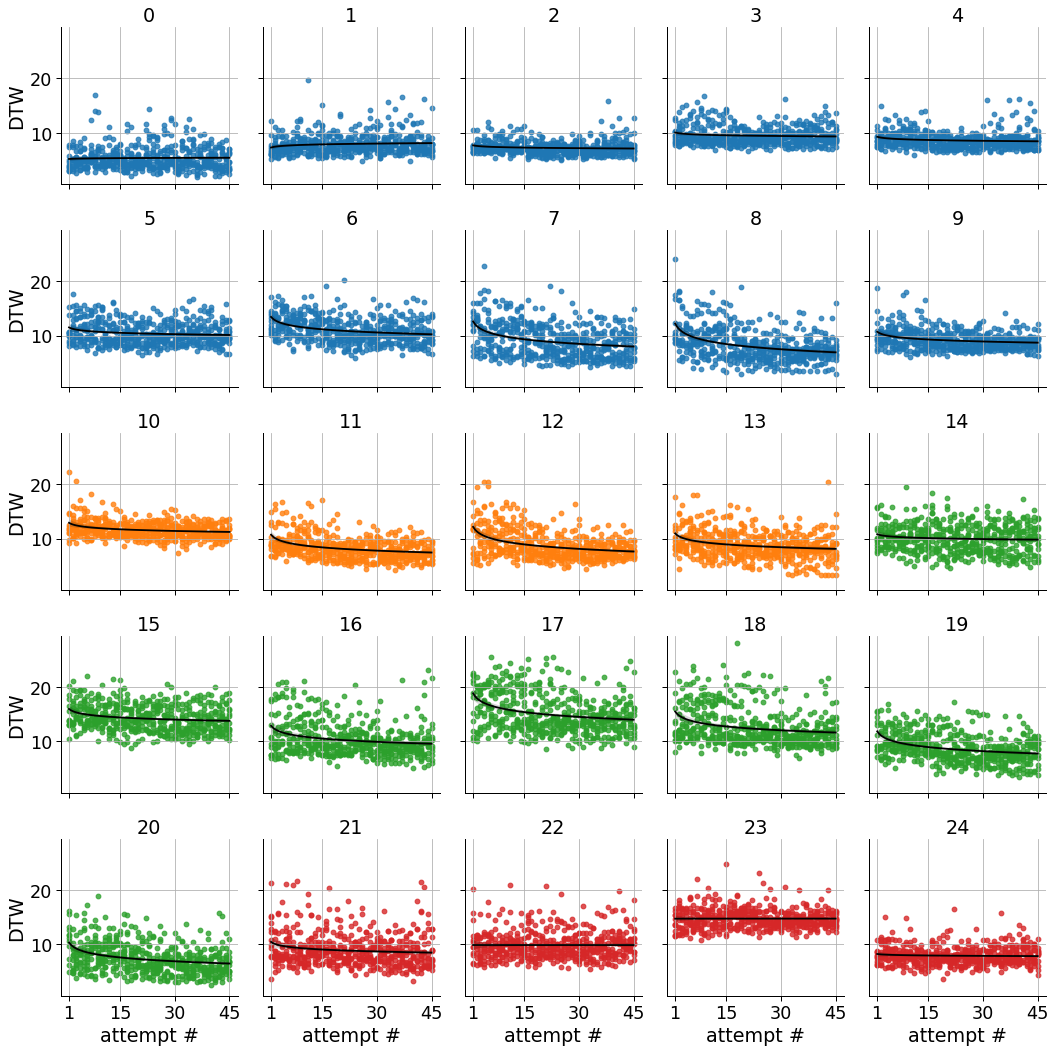

In [30]:
sns.set_context("paper", font_scale=2)

g = sns.FacetGrid(mse_t_plot, col="variable", col_wrap=5, hue="variable", palette=palette_mse_t_lr)
g.map(sns.regplot, 'x', 'value', logx=True, line_kws={"color": "black"})

# styling
g.set_titles(col_template = '{col_name}')
g.set_axis_labels("attempt #", "DTW")

# mse_s_lr.groupby("variable")["p"].agg(lambda x: (x < 0.01).all())
for axis in g.axes:
    axis.grid()
    axis.set_xticks([1, 15, 30, 45])
#     if axis.get_title() in [str(i) for i in [0,1,2,3,4,5,10,13,14,15,16,18,21,22,23,24]]:
#         axis.set_facecolor((0.0, 0.0, 0.0, 0.1))

if SAVEFIG:
    g.fig.tight_layout()
    g.fig.savefig("./figs/temporal_learningrate.png")

In [31]:
def compute_learningrate_rkf(grp):
    rkf = skms.RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    users_ids = np.array(list(set(annotations_select['user'])))
    
    res = []
    for fold_id, (train_ids, test_ids) in enumerate(rkf.split(np.arange(len(users_ids)))):
        data = select(grp, user=list(users_ids[test_ids]))
        # res.append([fold_id, so.curve_fit(lambda t,a,b: a+b*np.log(t),  data['x'], data['value'])[0][1]])
        lm = pg.linear_regression(np.log(data['x']), data['value'])
        tmp = lm.iloc[1][['coef', 'pval']].values
        res.append([fold_id, *tmp])
        
    res = pd.DataFrame(res, columns=["fold", "B", "p"])
    
    return res

In [32]:
def compute_learningrate_bootstrap(grp):
    res = []
    for fold_id in range(n_bootstrap):
        data = grp.sample(n=len(grp), replace=True)
        lm = pg.linear_regression(np.log(data['x']), data['value'])
        tmp = lm.iloc[1][['coef', 'pval']].values
        res.append([fold_id, *tmp])
        
    res = pd.DataFrame(res, columns=["fold", "B", "p"])
    
    return res

In [33]:
%%time
# fun = compute_learningrate_rkf
fun = compute_learningrate_bootstrap
mse_t_lr = mse_t_plot.astype({"variable":int}).groupby("variable").apply(fun)

CPU times: user 18.8 s, sys: 348 ms, total: 19.2 s
Wall time: 3.2 s


In [34]:
mse_t_lr = mse_t_lr.reset_index()

In [35]:
mms = skprep.MinMaxScaler()
mse_t_lr["B_"] = mms.fit_transform(-mse_t_lr["B"].values.reshape(-1,1))

In [36]:
mse_t_lr["ss"] = mse_t_lr.groupby("variable")["p"].transform(lambda x: (x < 0.01).all())

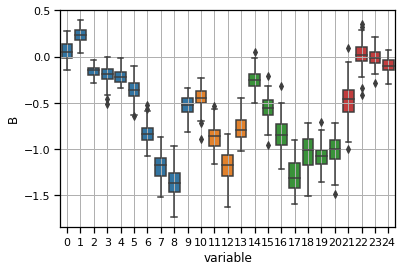

In [37]:
sns.set_context("notebook")
fig, ax = plt.subplots()
sns.boxplot(data=mse_t_lr, x="variable", y="B", palette=palette_mse_t_lr)
ax.grid()

## all together

In [38]:
columns = [i for i in range(N_SEGMENTS)]

In [39]:
weights = report.filter(regex="w.*")
weights.columns = columns

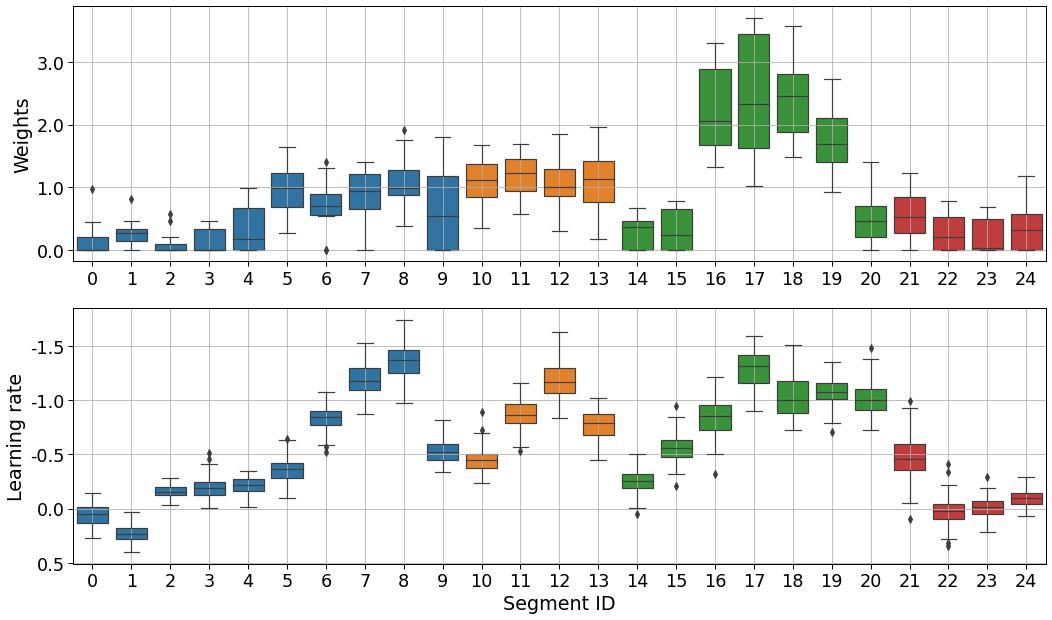

In [41]:
sns.set_context("paper", font_scale=2)

fig, axs = plt.subplots(2, 1, figsize=(15,9))

# weights
ax=axs[0]
bp = sns.boxplot(data=weights.melt(), x="variable", y="value", palette=palette_mse_t_lr, ax=ax)
ax.set_ylabel("Weights")
ax.set_yticks(np.arange(0, 4, 1))


# learning rate
ax=axs[1]
bp = sns.boxplot(data=mse_t_lr, x="variable", y="B", palette=palette_mse_t_lr, ax=ax)
ax.set_ylabel("Learning rate")
ax.invert_yaxis()    

axs[0].set_xlabel("")
axs[1].set_xlabel("Segment ID")

from matplotlib.ticker import FormatStrFormatter
for axis in axs: 
    axis.grid()
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

fig.tight_layout()
if SAVEFIG:
    fig.savefig("./figs/temporal_boxplots.pdf")

# analysis

In [42]:
lr_mean = mse_t_lr.groupby("variable")["B"].mean()

In [43]:
wg_mean = weights.mean()

In [44]:
pg.corr(wg_mean, lr_mean)

,n,r,CI95%,p-val,BF10,power
pearson,25,-0.714914,"[-0.87, -0.45]",0.000059,498.645,0.989632


In [45]:
data = weights.melt()

In [46]:
data.anova(between="variable", dv="value")

,Source,ddof1,ddof2,F,p-unc,np2
0,variable,24,375,41.217119,7.352819e-90,0.725116
